## Star-Galaxy Classification (Experiment 1) using Bayesian MargNet. Ensemble of ANN (for Photometric features), and CNN (for images). A variational layer is added after concatenating features from ANN and CNN.

#### Import libraries

In [13]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
np.random.seed(69)
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
sns.set()
# from tqdm.notebook 
import tqdm
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time
import pickle
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


#### 1. Load and extract the dataset

In [2]:
X = np.load("/scratch/srinadb/Foundation/Dataset/Experiment1/X_exp1.npy")
dnnx = np.load("/scratch/srinadb/Foundation//Dataset/Experiment1/dnnx_exp1.npy")
objlist = np.load("/scratch/srinadb/Foundation//Dataset/Experiment1/objlist_exp1.npy")
y = np.load("/scratch/srinadb/Foundation//Dataset/Experiment1/y_exp1.npy", allow_pickle=True)

idx_drop = np.where(y=="QSO")[0]
X = np.delete(X,idx_drop,axis=0)
dnnx = np.delete(dnnx,idx_drop,axis=0)
y = np.delete(y,idx_drop,axis=0)
objlist = np.delete(objlist,idx_drop,axis=0)
y, label_strings = pd.factorize(y,sort=True)
# y = to_categorical(y)
print('\n')
print(label_strings)




['GALAXY' 'STAR']


In [3]:
zipX = list(zip(X, dnnx))
zipy = list(zip(y, objlist))

zipX_train, zipX_test, zipy_train, zipy_test = train_test_split(zipX, zipy, test_size = 0.125,random_state=42)
zipX_train, zipX_val, zipy_train, zipy_val = train_test_split(zipX_train, zipy_train, test_size = 0.1428, random_state=42)

X_train, dnnx_train = zip(*zipX_train)
X_val, dnnx_val = zip(*zipX_val)
X_test, dnnx_test = zip(*zipX_test)

y_train, objlist_train = zip(*zipy_train)
y_val, objlist_val = zip(*zipy_val)
y_test, objlist_test = zip(*zipy_test)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

dnnx_train = np.array(dnnx_train)
dnnx_val = np.array(dnnx_val)
dnnx_test = np.array(dnnx_test)

y_train = np.array(y_train)
objlist_train = np.array(objlist_train)
y_val = np.array(y_val)
objlist_val = np.array(objlist_val)
y_test = np.array(y_test)
objlist_test = np.array(objlist_test)

del(zipX,zipX_test,zipX_train,zipX_val, X, zipy, zipy_test, zipy_train, zipy_val, objlist)

X_train = X_train.transpose((0, 3, 1, 2))
X_val = X_val.transpose((0, 3, 1, 2))
X_test = X_test.transpose((0, 3, 1, 2))


print('The shape of the Train data is:', dnnx_train.shape)
print('The shape of the Validation data is:', dnnx_val.shape)
print('The shape of the Test data is:', dnnx_test.shape)
print('\n')
print('The shape of the Train data is:', X_train.shape)
print('The shape of the Validation data is:', X_val.shape)
print('The shape of the Test data is:', X_test.shape)



The shape of the Train data is: (120007, 24)
The shape of the Validation data is: (19992, 24)
The shape of the Test data is: (20000, 24)


The shape of the Train data is: (120007, 5, 32, 32)
The shape of the Validation data is: (19992, 5, 32, 32)
The shape of the Test data is: (20000, 5, 32, 32)


In [4]:
def get_metrics(y_pred, y_test, labels, to_print=True):
    correct_labels = np.where(y_pred==y_test)[0]
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred,average='macro')
    recall = metrics.recall_score(y_test, y_pred,average='macro')
    f1score = metrics.f1_score(y_test, y_pred,average='macro')
    # rocscore = metrics.roc_auc_score(y_test, y_pred,average='micro',multi_class="ovo")
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)  
    classification_report = metrics.classification_report(y_test, y_pred)

    if to_print:
        print("Identified {} correct labels out of {} labels".format(len(correct_labels), y_test.shape[0]))
        print("Accuracy:",accuracy)
        print("Precision:",precision)
        print("Recall:",recall)
        print("F1 Score:",f1score)
        # print("ROC AUC Score:",rocscore)
        print(f"Labels are: {labels}")
        print("Confusion Matrix:\n", confusion_matrix)
        print("Classification_Report:\n", classification_report)

    return (correct_labels, accuracy, precision, recall, confusion_matrix, classification_report)


### 1. ANN Model using Photometric Features

##### Create dataset and dataloader for pytorch training

In [5]:
class SGData_pf(Dataset):
    def __init__(self, x, y, transform=None):
        self.n_samples = x.shape[0]
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y)
        self.transform = transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, i):
        inputs, targets = self.x[i], self.y[i]

        if self.transform:
            inputs = self.transform(inputs)

        return inputs, targets

# Create DataLoader for training and validation data
pf_train_dataset = SGData_pf(dnnx_train, y_train, transform=None)
pf_train_loader = DataLoader(pf_train_dataset, batch_size=2048, shuffle=True, num_workers=8)
pf_val_dataset = SGData_pf(dnnx_val, y_val, transform=None)
pf_val_loader = DataLoader(pf_val_dataset, batch_size=2048, shuffle=False, num_workers=4)
pf_test_dataset = SGData_pf(dnnx_test, y_test)
pf_test_loader = DataLoader(pf_test_dataset, batch_size=2048, shuffle=False)


#### Initialize or Define the Model

In [6]:
# Define the custom PyTorch model

class DNNModel(nn.Module):
    def __init__(self, input_dim, n_classes):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.dropout1 = nn.Dropout(0.25)
        # self.activation = torch.nn.sigmoid()
        self.fc2 = nn.Linear(1024, 256)
        self.dropout2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(0.25)
        self.fc4 = nn.Linear(128, 64)
        self.dropout4 = nn.Dropout(0.25)
        self.fc5 = nn.Linear(64, 32)
        self.dropout5 = nn.Dropout(0.25)
        self.fc6 = nn.Linear(32, n_classes)        

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.dropout1(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        x = self.dropout3(x)
        x = torch.sigmoid(self.fc4(x))
        x = self.dropout4(x)
        x = torch.sigmoid(self.fc5(x))
        x = self.dropout5(x)
        x = self.fc6(x)
        return x

# Initialize the PyTorch model
pf_input_dim = dnnx_train.shape[1]
n_classes = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
pf_model = DNNModel(pf_input_dim, n_classes).to(device)
        

cuda:0


#### Training the model

Epoch [1/4000] - Train Loss: 0.7014, Train Accuracy: 0.5008, Validation Loss: 0.6918, Validation Accuracy: 0.4982
Epoch [2/4000] - Train Loss: 0.5446, Train Accuracy: 0.7406, Validation Loss: 0.2543, Validation Accuracy: 0.9248
Epoch [3/4000] - Train Loss: 0.2348, Train Accuracy: 0.9262, Validation Loss: 0.1761, Validation Accuracy: 0.9434
Epoch [4/4000] - Train Loss: 0.1875, Train Accuracy: 0.9389, Validation Loss: 0.1618, Validation Accuracy: 0.9462
Epoch [5/4000] - Train Loss: 0.1696, Train Accuracy: 0.9440, Validation Loss: 0.1357, Validation Accuracy: 0.9572
Epoch [6/4000] - Train Loss: 0.1525, Train Accuracy: 0.9504, Validation Loss: 0.1501, Validation Accuracy: 0.9484
Epoch [7/4000] - Train Loss: 0.1429, Train Accuracy: 0.9536, Validation Loss: 0.1210, Validation Accuracy: 0.9622
Epoch [8/4000] - Train Loss: 0.1376, Train Accuracy: 0.9555, Validation Loss: 0.1210, Validation Accuracy: 0.9605
Epoch [9/4000] - Train Loss: 0.1341, Train Accuracy: 0.9563, Validation Loss: 0.1147, Va

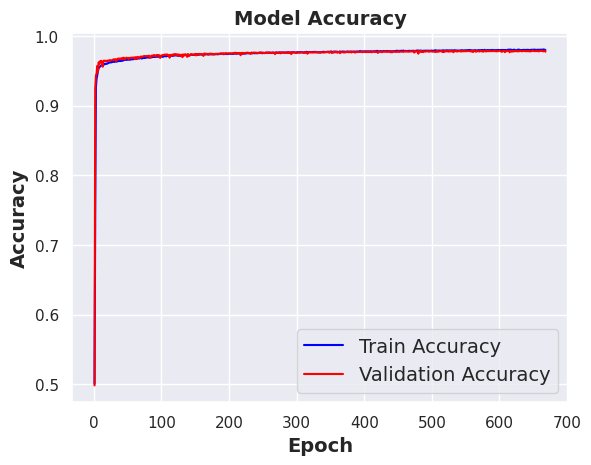

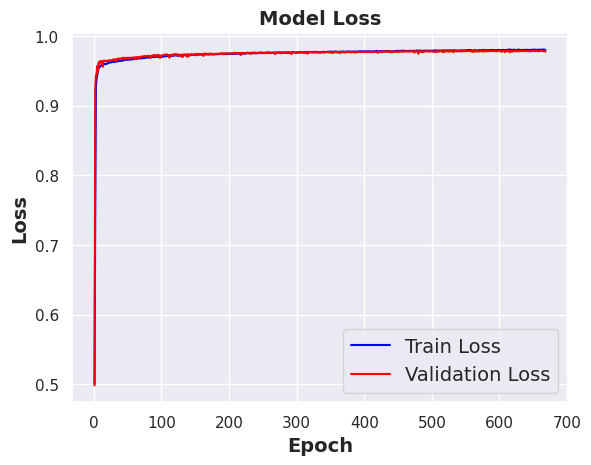

In [7]:
train_loss_arr = []
train_accuracy_arr = []
val_loss_arr = []
val_accuracy_arr = []

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pf_model.parameters())

# Early stopping parameters
patience = 100
best_val_loss = float('inf')
best_model_state = None  # Initialize a variable to store the best model state
counter = 0

# Training loop
epochs = 4000
epoch1 =0

for epoch in range(epochs):
    epoch1+=1
    pf_model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch_x, batch_y in pf_train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = pf_model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        total_train += batch_y.size(0)
        correct_train += predicted.eq(batch_y).sum().item()

    train_loss /= len(pf_train_loader)
    train_accuracy = correct_train / total_train
    train_loss_arr.append(train_loss)
    train_accuracy_arr.append(train_accuracy)
    
    pf_model.eval()
    
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_x, batch_y in pf_val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            output = pf_model(batch_x)
            val_loss += criterion(output, batch_y).item()
            _, predicted = output.max(1)
            total_val += batch_y.size(0)
            correct_val += predicted.eq(batch_y).sum().item()

    val_loss /= len(pf_val_loader)
    val_accuracy = correct_val / total_val
    val_loss_arr.append(val_loss)
    val_accuracy_arr.append(val_accuracy)
    
    pf_model.train()
        
    #Check for early stopping and save best model state
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = pf_model.state_dict()  # Store the current best model state
        torch.save(best_model_state, '/scratch/srinadb/Foundation/Trained_Models/MargNet/Experiment1/SG/EX1_SG_MargNet_DNN_Model.pth')
    else:
        counter += 1

    if counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        if best_model_state is not None:
            pf_model.load_state_dict(best_model_state)  # Restore best model state
        counter = 0  # Reset the counter    
        break

    print(f'Epoch [{epoch+1}/{epochs}] - '
      f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
      f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Create the range of epochs
epoch_range = range(1, epoch1+1)
    
# Plot training accuracy in blue
plt.figsize=(8, 6)  # Adjust the size as needed
plt.plot(epoch_range, train_accuracy_arr, label='Train Accuracy', color='blue')

# Plot validation accuracy in red
plt.plot(epoch_range, val_accuracy_arr, label='Validation Accuracy', color='red')

# Add labels and title
plt.xlabel('Epoch', fontsize=14, weight='bold')
plt.ylabel('Accuracy', fontsize=14, weight='bold')
plt.title('Model Accuracy', fontsize=14, weight='bold')

# Add a legend
plt.legend(fontsize=14, title_fontproperties={'weight':'bold'})
plt.savefig("/scratch/srinadb/Foundation/Trained_Models/MargNet/Experiment1/SG/EX1_SG_MargNet_DNN_Accuracy.png")
# Show the plot
plt.show()
plt.close()

# Plot training accuracy in blue
plt.figsize=(8, 6)  # Adjust the size as needed
plt.plot(epoch_range, train_accuracy_arr, label='Train Loss', color='blue')

# Plot validation accuracy in red
plt.plot(epoch_range, val_accuracy_arr, label='Validation Loss', color='red')

# Add labels and title
plt.xlabel('Epoch', fontsize=14, weight='bold')
plt.ylabel('Loss', fontsize=14, weight='bold')
plt.title('Model Loss', fontsize=14, weight='bold')

# Add a legend
plt.legend(fontsize=14, title_fontproperties={'weight':'bold'})
plt.savefig("/scratch/srinadb/Foundation/Trained_Models/MargNet/Experiment1/SG/EX1_SG_MargNet_DNN_Loss.png")
# Show the plot
plt.show()
plt.close()


#### Testing the Model

Identified 19573 correct labels out of 20000 labels
Accuracy: 0.97865
Precision: 0.9786465520402603
Recall: 0.9786569628842764
F1 Score: 0.9786496997614029
Labels are: ['GALAXY' 'STAR']
Confusion Matrix:
 [[9749  199]
 [ 228 9824]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      9948
           1       0.98      0.98      0.98     10052

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000

(array([    0,     1,     2, ..., 19997, 19998, 19999]), 0.97865, 0.9786465520402603, 0.9786569628842764, array([[9749,  199],
       [ 228, 9824]]), '              precision    recall  f1-score   support\n\n           0       0.98      0.98      0.98      9948\n           1       0.98      0.98      0.98     10052\n\n    accuracy                           0.98     20000\n   macro avg       0.98      0.98      0.9

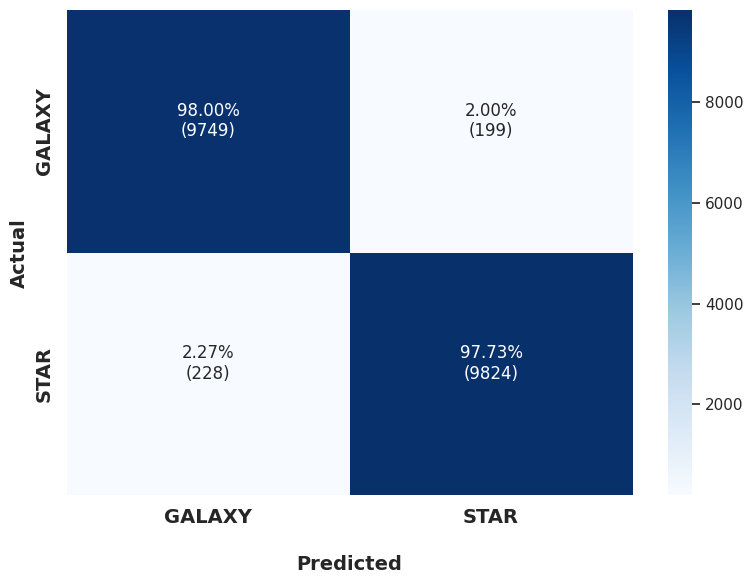

In [8]:
# Set the model to evaluation mode
pf_model.load_state_dict(torch.load('/scratch/srinadb/Foundation/Trained_Models/MargNet/Experiment1/SG/EX1_SG_MargNet_DNN_Model.pth', map_location=device))
pf_model.eval()
y_test_pred = torch.empty(0).to(device)

# Generate predictions
with torch.no_grad():
    for feats, labels in pf_test_loader:
        feats = feats.to(device)
        labels = labels.to(device)
        pred = pf_model(feats)

        y_test_pred = torch.cat((y_test_pred, pred), dim=0)

y_test_pred = y_test_pred.cpu().numpy()
y_test_pred = y_test_pred.argmax(axis=1)
print(get_metrics(y_test_pred, y_test, label_strings))

# https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#google_vignette
# fig = plt.figure()
cf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
cf_matrix_percentage = metrics.confusion_matrix(y_test, y_test_pred, normalize='true')
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_percentage.flatten()]
labels = [f"{v1}\n({v2})\n" for v1, v2 in
          zip(group_percentages,group_counts)]
labels = np.asarray(labels).reshape(2,2)
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the size as needed

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('\nPredicted', fontsize=14, weight='bold')
ax.set_ylabel('Actual', fontsize=14, weight='bold');
ax.xaxis.set_ticklabels(['GALAXY', 'STAR'], fontsize=14, weight='bold')
ax.yaxis.set_ticklabels(['GALAXY', 'STAR'], fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig("/scratch/srinadb/Foundation/Trained_Models/MargNet/Experiment1/SG/EX1_SG_MargNet_DNN_CM.png")
plt.show()
plt.close()


### 2. CNN Model using Images

##### Create dataset and dataloader for pytorch training

In [9]:
class SGData_image(Dataset):
    def __init__(self, x, y, transform=None):
        self.n_samples = x.shape[0]
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y)
        self.transform = transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, i):
        inputs, targets = self.x[i], self.y[i]
        
        if self.transform:
            inputs = self.transform(inputs)

        return inputs, targets

# Define your data augmentation transformations
image_transform = transforms.Compose([    
    transforms.RandomRotation(180),
    transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

# Create DataLoader for training and validation data
image_train_dataset = SGData_image(X_train, y_train, transform=image_transform)
image_train_loader = DataLoader(image_train_dataset, batch_size=512, shuffle=True, num_workers=8)
image_val_dataset = SGData_image(X_val, y_val, transform=image_transform)
image_val_loader = DataLoader(image_val_dataset, batch_size=512, shuffle=False, num_workers=4)
image_test_dataset = SGData_image(X_test, y_test, transform=None)
image_test_loader = DataLoader(image_test_dataset, batch_size=512, shuffle=False, num_workers=4)


#### Initialize or Define the Model

In [10]:
# Initialize the PyTorch model
in_channels = X_train.shape[1]
image_ht = X_train.shape[2]
image_wt = X_train.shape[3]

class InceptionLikeNet(nn.Module):
    def __init__(self, in_channels, img_height, img_width, num_classes=2):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)

        # First conv
        self.conv0 = nn.Conv2d(in_channels, 64, kernel_size=5, padding=2)

        # --- Block 1 ---
        self.b1_c1_1x1 = nn.Conv2d(64, 48, kernel_size=1)
        self.b1_c2_1x1 = nn.Conv2d(64, 48, kernel_size=1)
        self.b1_c3_1x1 = nn.Conv2d(64, 48, kernel_size=1)
        self.b1_c4_1x1 = nn.Conv2d(48, 64, kernel_size=1)
        self.b1_c5_3x3 = nn.Conv2d(48, 64, kernel_size=3, padding=1)
        self.b1_c6_5x5 = nn.Conv2d(48, 64, kernel_size=5, padding=2)

        # shared pools
        self.pool1x1 = nn.AvgPool2d(kernel_size=1, stride=1)  # like AveragePooling2D((1,1))
        self.pool2x2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # --- Block 2 ---
        # input channels after block1 concat: 64+64+64+48 = 240
        self.b2_c7_1x1  = nn.Conv2d(240, 64, kernel_size=1)
        self.b2_c8_1x1  = nn.Conv2d(240, 64, kernel_size=1)
        self.b2_c9_1x1  = nn.Conv2d(240, 64, kernel_size=1)
        self.b2_c10_1x1 = nn.Conv2d(64, 92, kernel_size=1)
        self.b2_c11_3x3 = nn.Conv2d(64, 92, kernel_size=3, padding=1)
        self.b2_c12_5x5 = nn.Conv2d(64, 92, kernel_size=5, padding=2)
        # after concat: 92+92+92+64 = 340, then 2x2 avg pool

        # --- Block 3 ---
        self.b3_c13_1x1 = nn.Conv2d(340, 92, kernel_size=1)
        self.b3_c14_1x1 = nn.Conv2d(340, 92, kernel_size=1)
        self.b3_c15_1x1 = nn.Conv2d(340, 92, kernel_size=1)
        self.b3_c16_1x1 = nn.Conv2d(92, 128, kernel_size=1)
        self.b3_c17_3x3 = nn.Conv2d(92, 128, kernel_size=3, padding=1)
        self.b3_c18_5x5 = nn.Conv2d(92, 128, kernel_size=5, padding=2)
        # concat: 128+128+128+92 = 476

        # --- Block 4 ---
        self.b4_c19_1x1 = nn.Conv2d(476, 92, kernel_size=1)
        self.b4_c20_1x1 = nn.Conv2d(476, 92, kernel_size=1)
        self.b4_c21_1x1 = nn.Conv2d(476, 92, kernel_size=1)
        self.b4_c22_1x1 = nn.Conv2d(92, 128, kernel_size=1)
        self.b4_c23_3x3 = nn.Conv2d(92, 128, kernel_size=3, padding=1)
        self.b4_c24_5x5 = nn.Conv2d(92, 128, kernel_size=5, padding=2)
        # concat: 128+128+128+92 = 476, then 2x2 avg pool

        # --- Block 5 ---
        self.b5_c25_1x1 = nn.Conv2d(476, 92, kernel_size=1)
        self.b5_c26_1x1 = nn.Conv2d(476, 92, kernel_size=1)
        self.b5_c27_1x1 = nn.Conv2d(476, 128, kernel_size=1)
        self.b5_c28_3x3 = nn.Conv2d(92, 128, kernel_size=3, padding=1)
        # concat: 128+128+92 = 348

        # Dense part we need to know flattened size, so we build dynamically
        self._build_fc(in_channels, img_height, img_width, num_classes)

    # run only the conv part (up to Flatten in your Keras model)
    def _forward_features(self, x):
        x = self.relu(self.conv0(x))

        # Block 1
        c1 = self.relu(self.b1_c1_1x1(x))
        c2 = self.relu(self.b1_c2_1x1(x))
        c3 = self.relu(self.b1_c3_1x1(x))
        c4 = self.relu(self.b1_c4_1x1(c1))
        c5 = self.relu(self.b1_c5_3x3(c1))
        c6 = self.relu(self.b1_c6_5x5(c2))
        p1 = self.pool1x1(c3)
        x  = torch.cat([c4, c5, c6, p1], dim=1)      # 240 ch

        # Block 2
        c7  = self.relu(self.b2_c7_1x1(x))
        c8  = self.relu(self.b2_c8_1x1(x))
        c9  = self.relu(self.b2_c9_1x1(x))
        c10 = self.relu(self.b2_c10_1x1(c7))
        c11 = self.relu(self.b2_c11_3x3(c7))
        c12 = self.relu(self.b2_c12_5x5(c8))
        p2  = self.pool1x1(c9)
        x   = torch.cat([c10, c11, c12, p2], dim=1)  # 340 ch
        x   = self.pool2x2(x)

        # Block 3
        c13 = self.relu(self.b3_c13_1x1(x))
        c14 = self.relu(self.b3_c14_1x1(x))
        c15 = self.relu(self.b3_c15_1x1(x))
        c16 = self.relu(self.b3_c16_1x1(c13))
        c17 = self.relu(self.b3_c17_3x3(c13))
        c18 = self.relu(self.b3_c18_5x5(c14))
        p3  = self.pool1x1(c15)
        x   = torch.cat([c16, c17, c18, p3], dim=1)  # 476 ch

        # Block 4
        c19 = self.relu(self.b4_c19_1x1(x))
        c20 = self.relu(self.b4_c20_1x1(x))
        c21 = self.relu(self.b4_c21_1x1(x))
        c22 = self.relu(self.b4_c22_1x1(c19))
        c23 = self.relu(self.b4_c23_3x3(c19))
        c24 = self.relu(self.b4_c24_5x5(c20))
        p4  = self.pool1x1(c21)
        x   = torch.cat([c22, c23, c24, p4], dim=1)  # 476 ch
        x   = self.pool2x2(x)

        # Block 5
        c25 = self.relu(self.b5_c25_1x1(x))
        c26 = self.relu(self.b5_c26_1x1(x))
        c27 = self.relu(self.b5_c27_1x1(x))
        c28 = self.relu(self.b5_c28_3x3(c25))
        p5  = self.pool1x1(c26)
        x   = torch.cat([c27, c28, p5], dim=1)       # 348 ch

        return x

    def _build_fc(self, in_channels, img_height, img_width, num_classes):
        # run a dummy tensor through conv part to figure out Flatten size
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, img_height, img_width)
            feats = self._forward_features(dummy)
            flatten_dim = feats.view(1, -1).shape[1]

        self.flatten = nn.Flatten()
        # Keras: Flatten -> Dense(1024) -> Dense(1024) -> Dense(2, softmax)
        # (no activations between Dense in your code; keeping that)
        self.fc1 = nn.Linear(flatten_dim, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self._forward_features(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        logits = self.fc3(x)   # raw scores; use CrossEntropyLoss (includes softmax)
        return logits

image_model = InceptionLikeNet(in_channels=in_channels, img_height=image_ht, img_width=image_wt, num_classes=n_classes).to(device)


#### Training the Model



Epoch [1/300] - Train Loss: 0.2888, Train Accuracy: 0.8856, Validation Loss: 0.1536, Validation Accuracy: 0.9490
Epoch [2/300] - Train Loss: 0.1412, Train Accuracy: 0.9521, Validation Loss: 0.1371, Validation Accuracy: 0.9558
Epoch [3/300] - Train Loss: 0.1327, Train Accuracy: 0.9545, Validation Loss: 0.1311, Validation Accuracy: 0.9577
Epoch [4/300] - Train Loss: 0.1248, Train Accuracy: 0.9570, Validation Loss: 0.1239, Validation Accuracy: 0.9593
Epoch [5/300] - Train Loss: 0.1181, Train Accuracy: 0.9595, Validation Loss: 0.1319, Validation Accuracy: 0.9589
Epoch [6/300] - Train Loss: 0.1170, Train Accuracy: 0.9600, Validation Loss: 0.1241, Validation Accuracy: 0.9570
Epoch [7/300] - Train Loss: 0.1098, Train Accuracy: 0.9623, Validation Loss: 0.1169, Validation Accuracy: 0.9613
Epoch [8/300] - Train Loss: 0.1082, Train Accuracy: 0.9624, Validation Loss: 0.1118, Validation Accuracy: 0.9615
Epoch [9/300] - Train Loss: 0.1078, Train Accuracy: 0.9631, Validation Loss: 0.1124, Validatio

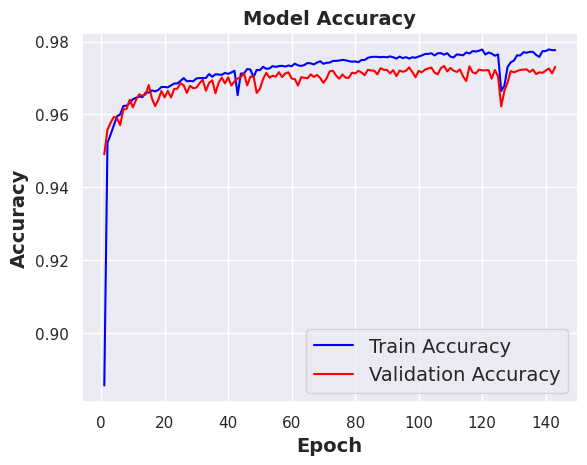

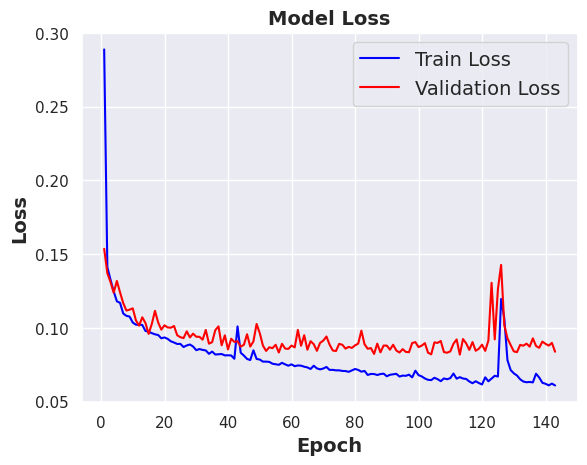

In [11]:
train_loss_arr = []
train_accuracy_arr = []
val_loss_arr = []
val_accuracy_arr = []

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(image_model.parameters())

# Early stopping parameters
patience = 30
best_val_loss = float('inf')
best_model_state = None  # Initialize a variable to store the best model state
counter = 0

# Training loop
epochs = 300
epoch1 =0
print('\n')
for epoch in range(epochs):
    epoch1+=1
    image_model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch_x, batch_y in image_train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = image_model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        total_train += batch_y.size(0)
        correct_train += predicted.eq(batch_y).sum().item()

    train_loss /= len(image_train_loader)
    train_accuracy = correct_train / total_train
    train_loss_arr.append(train_loss)
    train_accuracy_arr.append(train_accuracy)
    
    image_model.eval()
    
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_x, batch_y in image_val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            output = image_model(batch_x)
            val_loss += criterion(output, batch_y).item()
            _, predicted = output.max(1)
            total_val += batch_y.size(0)
            correct_val += predicted.eq(batch_y).sum().item()

    val_loss /= len(image_val_loader)
    val_accuracy = correct_val / total_val
    val_loss_arr.append(val_loss)
    val_accuracy_arr.append(val_accuracy)
    
    image_model.train()
        
    #Check for early stopping and save best model state
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = image_model.state_dict()  # Store the current best model state
        torch.save(best_model_state, "/scratch/srinadb/Foundation/Trained_Models/MargNet/Experiment1/SG/EX1_SG_MargNet_CNN_Model.pth")
    else:
        counter += 1

    if counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        if best_model_state is not None:
            image_model.load_state_dict(best_model_state)  # Restore best model state
        counter = 0  # Reset the counter    
        break

    print(f'Epoch [{epoch+1}/{epochs}] - '
      f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
      f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Create the range of epochs
epoch_range = range(1, epoch1+1)

# Plot training accuracy in blue
plt.figsize=(8, 6)  # Adjust the size as needed
plt.plot(epoch_range, train_accuracy_arr, label='Train Accuracy', color='blue')

# Plot validation accuracy in red
plt.plot(epoch_range, val_accuracy_arr, label='Validation Accuracy', color='red')

# Add labels and title
plt.xlabel('Epoch', fontsize=14, weight='bold')
plt.ylabel('Accuracy', fontsize=14, weight='bold')
plt.title('Model Accuracy', fontsize=14, weight='bold')

# Add a legend
plt.legend(fontsize=14, title_fontproperties={'weight':'bold'})
plt.savefig("/scratch/srinadb/Foundation/Trained_Models/MargNet/Experiment1/SG/EX1_SG_MargNet_CNN_Accuracy.png")
# Show the plot
plt.show()
plt.close()

# Plot training accuracy in blue
plt.figsize=(8, 6)  # Adjust the size as needed
plt.plot(epoch_range, train_loss_arr, label='Train Loss', color='blue')

# Plot validation accuracy in red
plt.plot(epoch_range, val_loss_arr, label='Validation Loss', color='red')

# Add labels and title
plt.xlabel('Epoch', fontsize=14, weight='bold')
plt.ylabel('Loss', fontsize=14, weight='bold')
plt.title('Model Loss', fontsize=14, weight='bold')

# Add a legend
plt.legend(fontsize=14, title_fontproperties={'weight':'bold'})
plt.savefig("/scratch/srinadb/Foundation/Trained_Models/MargNet/Experiment1/SG/EX1_SG_MargNet_CNN_Loss.png")
# Show the plot
plt.show()
plt.close()


#### Testing the Model



Identified 19473 correct labels out of 20000 labels
Accuracy: 0.97365
Precision: 0.9736562611421562
Recall: 0.9736438273290909
F1 Score: 0.9736489706629166
Labels are: ['GALAXY' 'STAR']
Confusion Matrix:
 [[9674  274]
 [ 253 9799]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      9948
           1       0.97      0.97      0.97     10052

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

(array([    0,     1,     2, ..., 19997, 19998, 19999]), 0.97365, 0.9736562611421562, 0.9736438273290909, array([[9674,  274],
       [ 253, 9799]]), '              precision    recall  f1-score   support\n\n           0       0.97      0.97      0.97      9948\n           1       0.97      0.97      0.97     10052\n\n    accuracy                           0.97     20000\n   macro avg       0.97      0.97      0

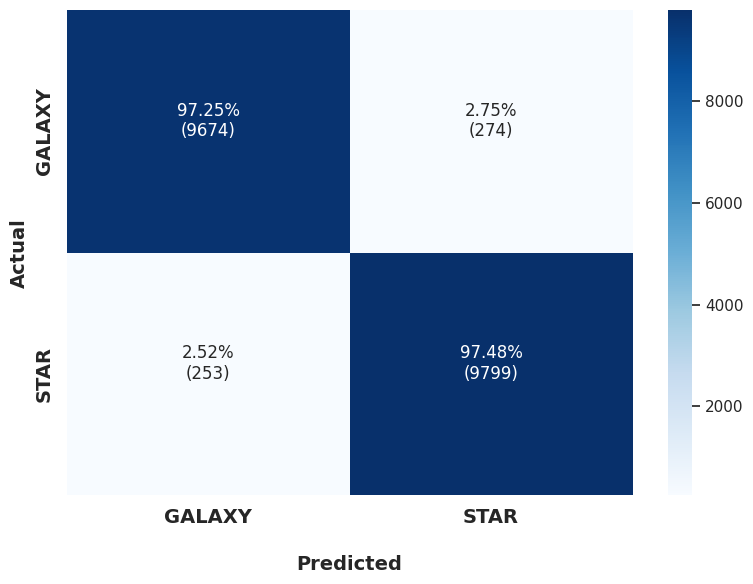

In [12]:
torch.cuda.empty_cache()

# Set the model to evaluation mode
image_model.load_state_dict(torch.load('/scratch/srinadb/Foundation/Trained_Models/MargNet/Experiment1/SG/EX1_SG_MargNet_CNN_Model.pth', map_location=device))
image_model.eval()

y_test_pred = torch.empty(0).to(device)
print('\n')
# Generate predictions
with torch.no_grad():
    for images, labels in image_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        pred = image_model(images)

        y_test_pred = torch.cat((y_test_pred, pred), dim=0)

y_test_pred = y_test_pred.cpu().numpy()
y_test_pred = y_test_pred.argmax(axis=1)
print(get_metrics(y_test_pred, y_test, label_strings))

# https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#google_vignette
# fig = plt.figure()
cf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
cf_matrix_percentage = metrics.confusion_matrix(y_test, y_test_pred, normalize='true')
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_percentage.flatten()]
labels = [f"{v1}\n({v2})\n" for v1, v2 in
          zip(group_percentages,group_counts)]
labels = np.asarray(labels).reshape(2,2)
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the size as needed

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('\nPredicted', fontsize=14, weight='bold')
ax.set_ylabel('Actual', fontsize=14, weight='bold');
ax.xaxis.set_ticklabels(['GALAXY', 'STAR'], fontsize=14, weight='bold')
ax.yaxis.set_ticklabels(['GALAXY', 'STAR'], fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig("/scratch/srinadb/Foundation/Trained_Models/MargNet/Experiment1/SG/EX1_SG_MargNet_CNN_CM.png")
plt.show()
plt.close()


### 3. Ensemble Model MargNet (ANN+CNN) using photometric features and Images with variational layer.

In [35]:
# Variational building blocks
class PosteriorMeanField(nn.Module):
    """
    Mean-field Gaussian posterior over flattened params theta.
    theta ~ N(loc, scale^2)
    loc, raw_scale ~ N(0, 0.1^2)
    scale = 1e-3 * softplus(c + raw_scale), c = log(expm1(1.))
    """
    def __init__(self, n: int):
        super().__init__()
        self.n = n
        self.c = math.log(math.expm1(1.0))

        loc_init = torch.empty(n).normal_(mean=0.0, std=0.1)
        raw_scale_init = torch.empty(n).normal_(mean=0.0, std=0.1)

        self.loc = nn.Parameter(loc_init)
        self.raw_scale = nn.Parameter(raw_scale_init)

    def mean(self):
        return self.loc

    def std(self):
        return 1e-3 * F.softplus(self.c + self.raw_scale) + 1e-8


class PriorTrainable(nn.Module):
    """
    Trainable prior:
      theta ~ N(mu_p, 1^2)
    mu_p init ~ N(0, 0.1^2)
    """
    def __init__(self, n: int):
        super().__init__()
        loc_init = torch.empty(n).normal_(mean=0.0, std=0.1)
        self.loc = nn.Parameter(loc_init)
        self.register_buffer("scale", torch.ones(n))

    def mean(self):
        return self.loc

    def std(self):
        return self.scale


class VariationalLinear(nn.Module):
    """
    DenseVariational-like layer for classification/regression.
    forward(x) -> (output, KL)
    """
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.bias_flag = bias

        n_weights = in_features * out_features
        n_bias = out_features if bias else 0
        self.n_weights = n_weights
        self.n_total = n_weights + n_bias

        self.posterior = PosteriorMeanField(self.n_total)
        self.prior = PriorTrainable(self.n_total)

    def _sample_weight_and_bias(self):
        mu_q = self.posterior.mean()
        sigma_q = self.posterior.std()
        eps = torch.randn_like(mu_q)
        theta = mu_q + sigma_q * eps

        weight = theta[:self.n_weights].view(self.out_features, self.in_features)
        bias = theta[self.n_weights:] if self.bias_flag else None
        return weight, bias

    def kl_divergence(self):
        mu_q = self.posterior.mean()
        sigma_q = self.posterior.std()
        mu_p = self.prior.mean()
        sigma_p = self.prior.std()

        var_q = sigma_q ** 2
        var_p = sigma_p ** 2

        kl_per_dim = torch.log(sigma_p / sigma_q) \
                     + (var_q + (mu_q - mu_p) ** 2) / (2.0 * var_p) - 0.5
        return kl_per_dim.sum()

    def forward(self, x):
        weight, bias = self._sample_weight_and_bias()
        out = F.linear(x, weight, bias)
        kl = self.kl_divergence()
        return out, kl


In [36]:
cnnclassifier = image_model
dnnclassifier = pf_model

checkpoint_image = torch.load('/scratch/srinadb/Foundation/Trained_Models/MargNet/Experiment1/SG/EX1_SG_MargNet_CNN_Model.pth')
checkpoint_pf = torch.load('/scratch/srinadb/Foundation/Trained_Models/MargNet/Experiment1/SG/EX1_SG_MargNet_DNN_Model.pth')

cnnclassifier.load_state_dict(checkpoint_image)
dnnclassifier.load_state_dict(checkpoint_pf)

cnnclassifier.to(device)
dnnclassifier.to(device)


DNNModel(
  (fc1): Linear(in_features=24, out_features=1024, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (dropout4): Dropout(p=0.25, inplace=False)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (dropout5): Dropout(p=0.25, inplace=False)
  (fc6): Linear(in_features=32, out_features=2, bias=True)
)

In [37]:
# STACKED MODEL WITH ONE BAYESIAN DENSE LAYER 
class StackedBayesModel(nn.Module):
    def __init__(self, members, n_classes):
        """
        members: list of pretrained models
                 e.g. [cnn_base, dnn_base]
        Each member i takes inputs[i] in forward().
        We assume each member outputs logits of shape (B, n_classes).
        """
        super().__init__()
        self.members = nn.ModuleList(members)
        self.n_members = len(members)
        self.n_classes = n_classes

        # Freeze base models
        for m in self.members:
            for p in m.parameters():
                p.requires_grad = False
            m.eval()

        # Concatenated dim = n_members * n_classes
        fused_dim = self.n_members * n_classes

        # ---- ONE Bayesian dense layer ----
        self.bayes = VariationalLinear(fused_dim, n_classes)

    def train(self, mode: bool = True):
        # keep members in eval mode, Bayesian head follows mode
        super().train(mode)
        for m in self.members:
            m.eval()
        return self

    def forward(self, inputs):
        """
        inputs: list/tuple of inputs for each member,
                same pattern as your old StackedModel:
                outputs = [model(inputs[i]) for i, model in enumerate(self.members)]
        Example call:
            logits, kl = model([batch_x_img, batch_x_pf])
        or
            logits, kl = model([batch_x1, batch_x2])
        depending on order.
        """
        # Run each member
        with torch.no_grad():
            member_outputs = [m(inputs[i]) for i, m in enumerate(self.members)]
        merge = torch.cat(member_outputs, dim=1)  # (B, n_members * n_classes)

        logits, kl = self.bayes(merge)
        return logits, kl

# Instantiate stacked Bayesian model
members = [cnnclassifier, dnnclassifier]   # order matters: match training call
model = StackedBayesModel(members, n_classes=n_classes).to(device)

# print(stacked_model)


In [38]:
# Convert data to PyTorch tensors and create DataLoader
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
dnnx_val_tensor = torch.tensor(dnnx_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

dataset = TensorDataset(X_val_tensor, dnnx_val_tensor, y_val_tensor)
dataloader = DataLoader(dataset, batch_size=512, shuffle=False)


#### Training the Model

In [39]:

# -----------------------------------------------------------------------------
# 3. TRAINING LOOP (SIMPLE VERSION)
# -----------------------------------------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 100
kl_weight = 1e-3  # tune or anneal
best_loss = float('inf')
best_state = None

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for batch_x_img, batch_x_pf, batch_y in dataloader:
        batch_x_pf  = batch_x_pf.to(device)
        batch_x_img = batch_x_img.to(device)
        batch_y     = batch_y.to(device)

        optimizer.zero_grad()

        logits, kl = model([batch_x_img, batch_x_pf])

        ce = criterion(logits, batch_y)
        loss = ce + kl_weight * kl

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = logits.max(1)
        total += batch_y.size(0)
        correct += predicted.eq(batch_y).sum().item()

    train_loss /= len(dataloader)
    train_acc = correct / total

    if train_loss < best_loss:
        best_loss = train_loss
        best_state = model.state_dict()
        torch.save(
            best_state,
            '/scratch/srinadb/Foundation/Trained_Models/MargNet/Experiment1/SG/EX1_SG_BayesianMargNet_Model.pth'
        )

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"- Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")

# Load best if needed
if best_state is not None:
    model.load_state_dict(best_state)


Epoch [1/100] - Loss: 1.2081, Acc: 0.0272
Epoch [2/100] - Loss: 1.1322, Acc: 0.0315
Epoch [3/100] - Loss: 1.0620, Acc: 0.0410
Epoch [4/100] - Loss: 0.9972, Acc: 0.0612
Epoch [5/100] - Loss: 0.9342, Acc: 0.1023
Epoch [6/100] - Loss: 0.8791, Acc: 0.1758
Epoch [7/100] - Loss: 0.8256, Acc: 0.2995
Epoch [8/100] - Loss: 0.7769, Acc: 0.4286
Epoch [9/100] - Loss: 0.7329, Acc: 0.5349
Epoch [10/100] - Loss: 0.6917, Acc: 0.6588
Epoch [11/100] - Loss: 0.6543, Acc: 0.7962
Epoch [12/100] - Loss: 0.6199, Acc: 0.8855
Epoch [13/100] - Loss: 0.5877, Acc: 0.9323
Epoch [14/100] - Loss: 0.5589, Acc: 0.9520
Epoch [15/100] - Loss: 0.5328, Acc: 0.9601
Epoch [16/100] - Loss: 0.5084, Acc: 0.9660
Epoch [17/100] - Loss: 0.4858, Acc: 0.9695
Epoch [18/100] - Loss: 0.4649, Acc: 0.9716
Epoch [19/100] - Loss: 0.4452, Acc: 0.9727
Epoch [20/100] - Loss: 0.4276, Acc: 0.9739
Epoch [21/100] - Loss: 0.4113, Acc: 0.9747
Epoch [22/100] - Loss: 0.3968, Acc: 0.9754
Epoch [23/100] - Loss: 0.3827, Acc: 0.9761
Epoch [24/100] - Los

In [40]:
model.load_state_dict(best_state)  # Restore best model state

<All keys matched successfully>

#### Testing the Model

In [41]:
# Convert data to PyTorch tensors and create DataLoader
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
dnnx_test_tensor = torch.tensor(dnnx_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

dataset1 = TensorDataset(X_test_tensor, dnnx_test_tensor, y_test_tensor)
dataloader1 = DataLoader(dataset1, batch_size=512, shuffle=False)


Identified 19622 correct labels out of 20000 labels
Accuracy: 0.9811
Precision: 0.9810967214781003
Recall: 0.9811041690567313
F1 Score: 0.9810996505325383
Labels are: ['GALAXY' 'STAR']
Confusion Matrix:
 [[9768  180]
 [ 198 9854]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      9948
           1       0.98      0.98      0.98     10052

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000

(array([    0,     1,     2, ..., 19997, 19998, 19999]), 0.9811, 0.9810967214781003, 0.9811041690567313, array([[9768,  180],
       [ 198, 9854]]), '              precision    recall  f1-score   support\n\n           0       0.98      0.98      0.98      9948\n           1       0.98      0.98      0.98     10052\n\n    accuracy                           0.98     20000\n   macro avg       0.98      0.98      0.98 

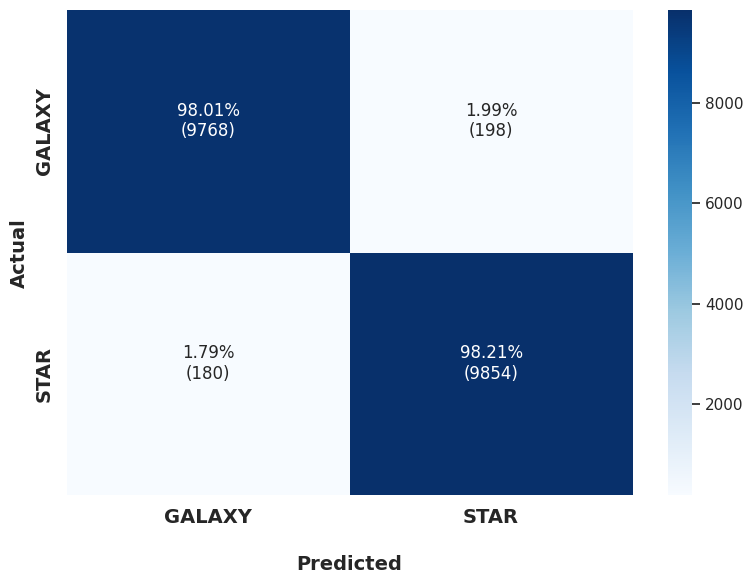

In [46]:
# Set the model to evaluation mode
model.load_state_dict(torch.load('/scratch/srinadb/Foundation/Trained_Models/MargNet/Experiment1/SG/EX1_SG_BayesianMargNet_Model.pth', map_location=device))
model.eval()

y_test_pred = torch.empty(0).to(device)

# Generate predictions
with torch.no_grad():
    for images, pfs, labels in dataloader1:
        images = images.to(device)
        pfs = pfs.to(device)
        labels = labels.to(device)
        pred, _ = model([images, pfs])

        y_test_pred = torch.cat((y_test_pred, pred), dim=0)

y_test_pred = y_test_pred.cpu().numpy()
y_test_pred = y_test_pred.argmax(axis=1)
print(get_metrics(y_test_pred, y_test, label_strings))

# https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#google_vignette
# fig = plt.figure()
cf_matrix = metrics.confusion_matrix(y_test_pred, y_test)
cf_matrix_percentage = metrics.confusion_matrix(y_test_pred, y_test, normalize='true')
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_percentage.flatten()]
labels = [f"{v1}\n({v2})\n" for v1, v2 in
          zip(group_percentages,group_counts)]
labels = np.asarray(labels).reshape(2,2)
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the size as needed

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('\nPredicted', fontsize=14, weight='bold')
ax.set_ylabel('Actual', fontsize=14, weight='bold');
ax.xaxis.set_ticklabels(['GALAXY', 'STAR'], fontsize=14, weight='bold')
ax.yaxis.set_ticklabels(['GALAXY', 'STAR'], fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig("/scratch/srinadb/Foundation/Trained_Models/BayesianMargNet/EX1_SG_MargNet_CM.png")
plt.show()
plt.close()

In [43]:
sum(p.numel() for p in model.parameters())
# 25874128

25874086